![example](images/director_shot.jpeg)

# Microsoft Movie Recommendations

**Author:** Lia Elwonger


## Overview
***

Microsoft is perhaps best know as a software company, but has many media holding, perhaps most notably in video games via their Xbox consoles and games. How might this company leverage its capital and brand to enter into the film industry?

In this project I analyze data from IMDB and The Numbers to find if there is any association between three variables: genre, director, and release date and the average profit made on a film.

As result of this analysis, I suggest that Microsoft:
* Release a Sci-Fi film.
* Hire Josh Whedon to direct it. 
* Aim to release the movie in May with June as a backup in case of delays.

## Business Problem
***

Microsoft has decided to create a new movie studio, but they lack experience in this market. There are many difficult problems facing new studios entering the market.

To aid in this endeavor we will give recommendations to help address three core problems that any studio will have to answer in the course of making a project:

* Determining what type of project to pursue.
* Determining what talent should be hired.
* Determining the timeline of the project.

To help answer elements of these problems we will investigate the answers to three related questions:

* What genre has had the high average profit in the past 20 years?
* What directors have had the highest average return in that genre?
* What month of the year is good to release a major film?

Picking a genre is necessary to give an initial outline to the projects, and hiring a director is a good way of determining what other talent is appropriate since they can bring their expertise to help answer lower level talent decisions.

## Data Understanding
***

In [1]:
# Import standard packages
import pandas as pd
import numpy as np

We will be using data from IMDB and The Numbers in our analysis.
Our target variable for all three recommendations will be mean profit.
We will look to see if there is any association between the target and three variables:
1. Film Genre
2. Time of Release
3. Director

### Budget, Revenue, and Release Date Data

The data on budgets, revenue and release date will come from the website "The Numbers". It includes data on production budget as well as both domestic and world wide gross revenue, all stored as objects rather than int. There is no data on non-production related expenses such as advertizing budgets, which can also deeply impact the profitability of a project. The release date data is stored as an object rather than datetime or int.

In [2]:
budgets_df = pd.read_csv('data/zippedData/tn.movie_budgets.csv.gz')
budgets_df.head(3)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"


In [3]:
budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


This dataset is free from missing data and doesn't have entirely duplicate rows, but does have multiple movies that are listed under identical names. For example, the 1978, 2007, and 2018 Halloween movies are just called Halloween.

In [4]:
budgets_df['movie'].value_counts()[:5]

Halloween        3
King Kong        3
Home             3
The Gift         2
Casino Royale    2
Name: movie, dtype: int64

In [5]:
budgets_df[budgets_df['movie'] == 'Halloween']

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
3014,15,"Aug 31, 2007",Halloween,"$15,000,000","$58,269,151","$77,514,401"
3535,36,"Oct 19, 2018",Halloween,"$10,000,000","$159,342,015","$254,900,667"
5536,37,"Oct 17, 1978",Halloween,"$325,000","$47,000,000","$70,000,000"


### Genre Data

The data on genres will come from IMDB and includes a column a containing comma seperated listing of the genres that the film has been categorized as, as well as name, runtime and release year.

In [6]:
titles_df = pd.read_csv('data/zippedData/imdb.title.basics.csv.gz')
titles_df.head(3)

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama


There is some missing runtime data and genre data and there is a similar issue of titles being repeated, which will have to be accounted for when merging the genre and budget dataframes.

In [7]:
titles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   tconst           146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [8]:
titles_df['primary_title'].value_counts()[:5]

Home          24
Broken        20
The Return    20
Alone         16
Homecoming    16
Name: primary_title, dtype: int64

### Director Data

Data for the directors names and films they worked on will come from IMDB as well and is spread over two files. One contains a listing on the role that each person perform on each film, but without their name. The other contains listing of the names of the people in the database along with the roles they typically serve, but without data on what role they play in each film they worked on. These will have to be joined.

In [9]:
principles_df = pd.read_csv('data/zippedData/imdb.title.principals.csv.gz')
principles_df.head(3)

,tconst,ordering,nconst,category,job,characters
0,tt0111414,1,nm0246005,actor,NaN,"[""The Man""]"
1,tt0111414,2,nm0398271,director,NaN,NaN
2,tt0111414,3,nm3739909,producer,producer,NaN


In [10]:
names_df = pd.read_csv("data/zippedData/imdb.name.basics.csv.gz") 
names_df.head(3)

,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department","tt0896534,tt6791238,tt0287072,tt1682940"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer","tt1470654,tt0363631,tt0104030,tt0102898"


Both dataset contain missing data, but not in the columns that will be relevant for our analysis.

In [11]:
principles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028186 entries, 0 to 1028185
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   tconst      1028186 non-null  object
 1   ordering    1028186 non-null  int64 
 2   nconst      1028186 non-null  object
 3   category    1028186 non-null  object
 4   job         177684 non-null   object
 5   characters  393360 non-null   object
dtypes: int64(1), object(5)
memory usage: 47.1+ MB


In [12]:
names_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606648 entries, 0 to 606647
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   nconst              606648 non-null  object 
 1   primary_name        606648 non-null  object 
 2   birth_year          82736 non-null   float64
 3   death_year          6783 non-null    float64
 4   primary_profession  555308 non-null  object 
 5   known_for_titles    576444 non-null  object 
dtypes: float64(2), object(4)
memory usage: 27.8+ MB


## Data Preparation
***

### Cleaning the Data on Genre and Release Year

We will begin by joining the dataframes containing the genre information and the budget information and droping some columns that are irrelevant to our analysis. We will join them using both the names of the movies and the release year on the assumption that there aren't identically named movies released in the same year. To do that we will have to extract the year from the release date in the budget dataframe.

In [13]:
from code import data_preparation as dp

In [14]:
budget_genre_df = dp.make_budget_genre_table(budgets_df, titles_df)
budget_genre_df.head(3)

,id,release_date,primary_title,production_budget,domestic_gross,worldwide_gross,start_year,tconst,genres
0,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",2011,tt1298650,"Action,Adventure,Fantasy"
1,3,2019-06-07,Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",2019,tt6565702,"Action,Adventure,Sci-Fi"
2,4,2015-05-01,Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",2015,tt2395427,"Action,Adventure,Sci-Fi"


In [15]:
budget_genre_df.shape

(1547, 9)

We likely lost a good bit of data because movies had slightly different names in the two databases. As mentioned above the data is missing a few rows of genre information. It is a fairly small bit of data, likely from films that are either difficult to categorize or no one bothered to on IMDB. We will just drop them since there is no good way to guess at what genres they may be.

In [16]:
budget_genre_df.dropna(inplace = True)
budget_genre_df.shape

(1541, 9)

Since microsoft is likely to spend a considerable amount on a film to make it worth their time, we will filter the data only contain movies with budgets over $10 million.
Since film trends are fairly variable, we will also drop movies that didn't release in the past 20 years.
We will also insert a column that calculates the global profit for each film, which will require turning the objects in the budget and gross columns into integers.

In [17]:
budget_genre_df = dp.filter_by_year_budget(budget_genre_df, 2001, 10000000)
budget_genre_df.shape

(1111, 10)

### Cleaning the Director Data

We are now in a position to analyze the relationship between both genre and release date with profit, but don't yet have the data on directors. To do so we will join this data base with the other two, group it by director and calculate the mean profit that each director has made. 

In [18]:
name_profession_df = dp.make_profession_table(principles_df, names_df, 'director')
name_profession_df.head(3)

,tconst,ordering,category,primary_name,primary_profession
nconst,,,,,
nm0000080,tt0069049,5,director,Orson Welles,"actor,director,writer"
nm0000095,tt1605783,5,director,Woody Allen,"writer,director,actor"
nm0000095,tt1182350,5,director,Woody Allen,"writer,director,actor"


We will now join it with the budget and genre table.

In [19]:
complete_df = dp.make_complete_table(budget_genre_df, name_profession_df)
complete_df.head(3)

,nconst,category,primary_name,release_date,primary_title,production_budget,domestic_gross,worldwide_gross,genres,profit
tconst,,,,,,,,,,
tt0249516,nm0440415,director,Lawrence Kasanoff,2012-12-31,Foodfight!,45000000.0,0.0,7.370600e+04,"Action,Animation,Comedy",-4.492629e+07
tt0365907,nm0291082,director,Scott Frank,2014-09-19,A Walk Among the Tombstones,28000000.0,26017685.0,6.210859e+07,"Action,Crime,Drama",3.410859e+07
tt0369610,nm1119880,director,Colin Trevorrow,2015-06-12,Jurassic World,215000000.0,652270625.0,1.648855e+09,"Action,Adventure,Sci-Fi",1.433855e+09


This table is slightly longer than the budget table because some movies have multiple directors.

In [20]:
complete_df.shape

(1172, 10)

We can also get rough idea of the directors with the most large budget films in the past 20 years.

In [21]:
complete_df['primary_name'].value_counts()[:5]

Steven Spielberg    7
Ridley Scott        6
Clint Eastwood      6
Tim Story           6
David Ayer          5
Name: primary_name, dtype: int64

We now have a dataframe connecting the directors to the profit they made on their movies and by having joined it to the budget df and droping missing values, we have limited our list to large budget films they made in the past 20 years.

## Data Modeling
***

### Genre Analysis

We will begin analyzing the genre data by constructing a table which give us the mean profit for each genre as well as the std deviation. This will give us a reasonable representation of the expected profit from each genre and a rough measure of the risk. Some of these genres are likely fairly rare in the past 20 years. We will drop and genres with less than 20 movies.

In [22]:
genre_list = dp.list_genres(budget_genre_df)
genre_stats_df = dp.genre_stats(budget_genre_df, genre_list, 20)
genre_stats_df.head()

,Mean Profit,Std of Profit
Sci-Fi,298.846666,358.501672
Animation,287.555493,282.446612
Adventure,259.595762,303.832014
Fantasy,188.353184,260.043287
Action,180.424955,272.253415


We will now construct a plot of the top ten movie genres sorted by mean profit.

In [23]:
from code import visualizations as vis

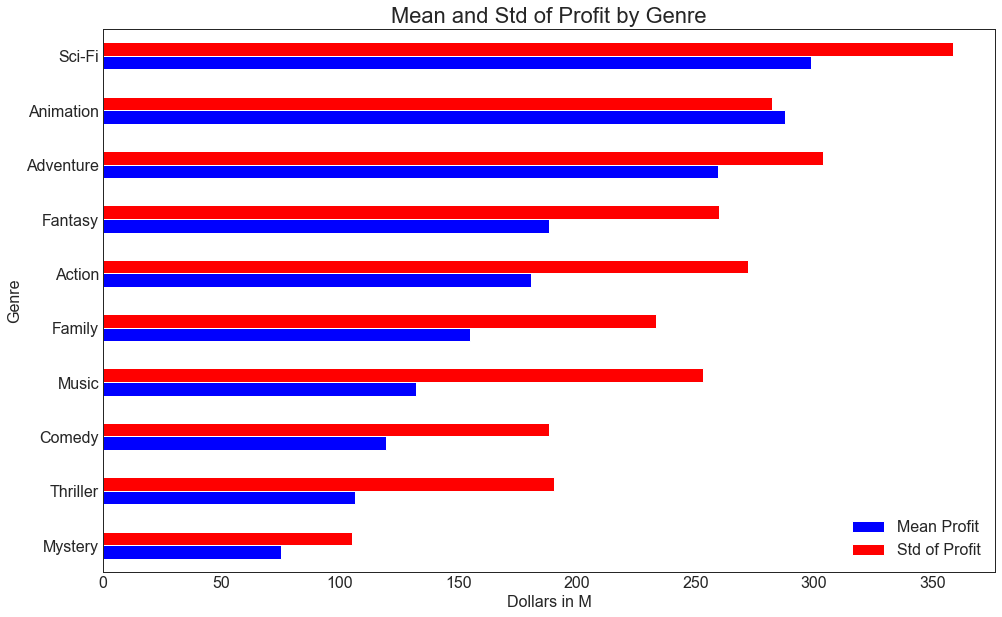

In [24]:
vis.plot_top_ten(genre_stats_df, 'Mean Profit', 'Genre');

Scifi has the highest mean profit of the genres with more than 20 movies in this data. Animation offers a good tradeoff between expect profit and risk, as it has the second best mean profit and is the only category where the std is less that the mean profit, meaning losses are fairly rare.

I would recommend the Sci-Fi genre. Although is is more risky, the risk goes both ways, it is more likely to lose money but also more likely to make a very large profit. The genre also synergizes well with microsofts other media and gaming projects. Sci-Fi movies are relatively easy to tie into video game like content, which also cross promotion opportunities. 

(That said animation offers toy and merchadise opportunities and would also be a reasonable choice.)

![Ship](/images/ship.png)

### Release Date Analysis

To determine what release month is best we group the data by month and find the mean and std of profit for each release month. 

In [25]:
release_df = dp.by_month_stats(budget_genre_df)
release_df

,Std of Profit,Mean Profit
release_month,,
1,75.889964,52.670377
2,179.215113,104.127889
3,228.120433,142.189183
4,288.066813,129.378726
5,279.283253,216.777256
6,312.394357,213.378872
7,235.632621,183.505442
8,114.108207,72.385334
9,102.581232,55.760578


Here is a chart of the mean and std of the profit by release month for *all* large budget movies in the past 20 years.

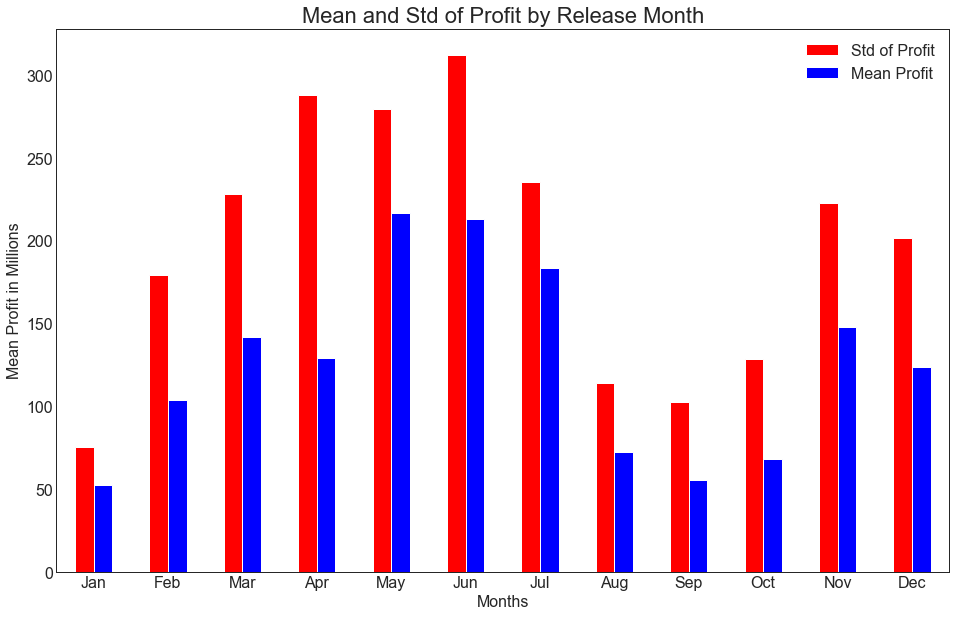

In [26]:
vis.month_plot(release_df);

And here is the same chart, but only including Sci-Fi movie releases.

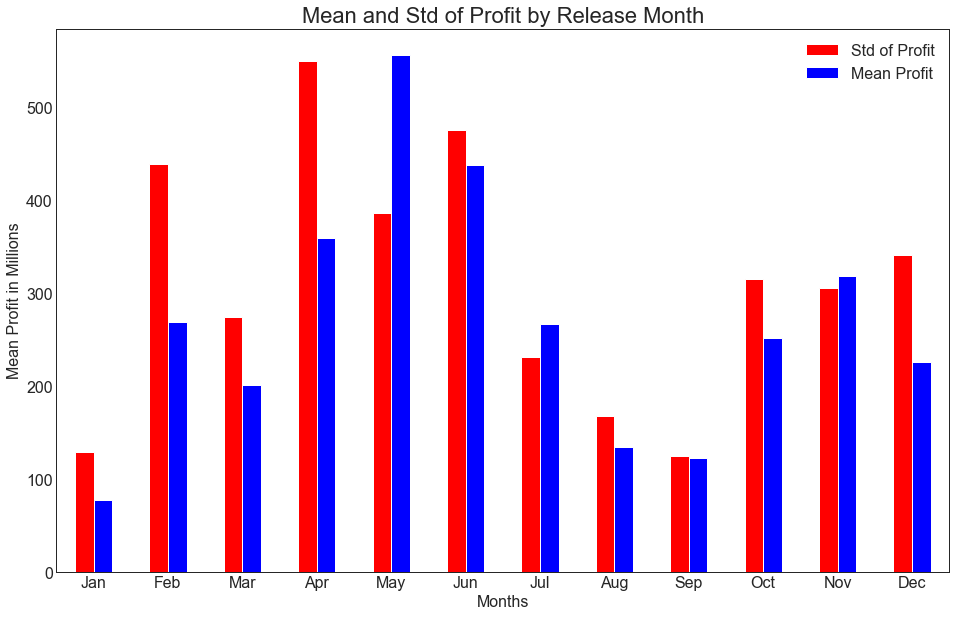

In [27]:
scifi_release_df = dp.by_month_stats(dp.genre_filter(budget_genre_df, 'Sci-Fi'))
vis.month_plot(scifi_release_df);

It appears that May has the highest mean profit, but July is almost as good with less variance. Any late spring to early summer release appears reasonable from this data. Shotting for a May release with a buffer for a potential June release in case of delays may be a good strategy.

![May Flowers](/images/may.png)

### Director Analysis

To determine what director would be reasonable we will filter the database to only include Sci-Fi movies and then group the database by director and sort them by the mean profit from their films to find the top 10 candidates. We will also linclude total profit, since some directors may have a high mean simply from having only directed one very successful film.

In [28]:
scifi_direct_df = dp.profession_stats(complete_df, 'Sci-Fi')
scifi_direct_df.head(10)

,Mean Profit,Total Profit
primary_name,,
Colin Trevorrow,1433.854864,1433.854864
Joss Whedon,1182.674930,2365.349860
Ryan Coogler,1148.258224,1148.258224
J.A. Bayona,1135.772799,1135.772799
Anthony Russo,1060.868501,3182.605502
Joe Russo,1060.868501,3182.605502
Anna Boden,948.061550,948.061550
Ryan Fleck,948.061550,948.061550
Ruben Fleischer,737.628605,737.628605


Here is a chart of the top ten Sci-Fi directors in total profit in the past 20 years, including their average profit per movie.

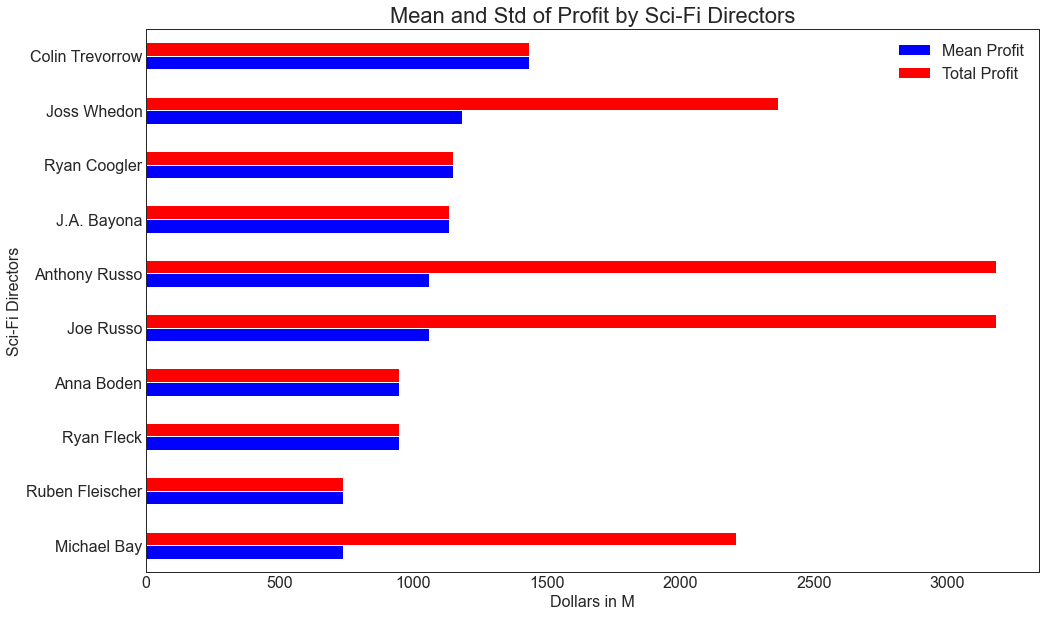

In [29]:
vis.plot_top_ten(scifi_direct_df, 'Mean Profit', 'Sci-Fi Directors');

Based on this analysis Josh Whedon offers a good balance of high average return with more of a track record of success. He also has writing talent which is a bonus since your new studio will also need writers for the project. That said, Josh has had a number or recent scandals that might affect his effectiveness as a directon. Colin Trevorrow would be a reasonable choice if the recent scandals Josh has been involved in are too much of a risk to the brand, or hiring him is morally unacceptable.

![Joss Whedon](/images/joss_whedon.png)

## Evaluation
***

Any analysis done with only this data will be inherently limited. 

To begin with, the data only contains information about production budgets and not other expenses. For instance, if Sci-Fi films are adversized much more than other film, then that would cut into the profit that this analysis suggest they have.

There are also problems with inferring causal claims from this data. For example, if Hollywood expects that summer is more profitable, they will likely release their big tent poll films during that time, which will then also skew the data into suggeesting the summer is profitable. With just this data, it is difficult to tell.

There are also numerous problems with making inferences from small samples, for example, many of the most profitable directors only made a couple of films, but it is not clear this will be very predictive of their success in new or different projects.

## Conclusions
***

My stated recommendations:

* Release a Sci-Fi film.
* Hire Joss Whedon to direct it. 
* Aim to release the movie in May with June as a backup in case of delays.

### Caveats and Future Work

This leaves many other issues unresolved. What script sould the movie use and should it be connected to other Microsoft media projects, which has potential rewards in increased sales in other areas such as video games, but also risks in damaging the brand if the movie fails. There is also the open question of other merchandise tie-ins.

I suggest that Microsoft:
* Do market research into what story types and themes are popular.
* Investigate whether it has existing media brands that would fit well with a Sci-Fi film.
* Investigate the Sci-Fi novel genre and see if any highly selling books would make for a good adaptation.